In [1]:
from utils import *
from scipy.stats import beta

# set up graphing rc
parameters = {'font.sans-serif': 'Times', 'font.size': 16.0}
plt.rcParams.update(parameters)

#TODO make this work with passed in axis 
def random_beta_sample(n_samples, dist, args, var, ax=None, verbose=False):
    if dist == "beta":
        a, b, spread, start = args
        xs = np.linspace(0, 1, 1000)
        
        if verbose:
            plt.figure() 
            plt.plot(xs, beta.pdf(xs, a, b))

            end = str(start + spread)
            plt.xticks(np.arange(2), ("1", f"{end}"))
            plt.yticks([])
            plt.title(f"PDF over which {var} is being sampled")
        
        return (np.random.beta(a, b, size=(n_samples)) * spread) + start
    
# Taken from Duraiswami et al 2014
duraiswami_data = [0.3636363636, 0.8571428571, 1.083333333, 0.6356589147, 0.7741935484, 0.5, 0.4583333333]

# Taken from Aubele et al 1988
aubele_data = [1.142857143, 1.346153846, 1,  0.5217391304, 1.076923077, 0.7777777778, 0.5, 0.5, 1.055555556, 0.6363636364, 0.6, 1.8, 0.4736842105, 0.1612903226, 0.2272727273, 1.294117647, 0.4, 2.12, 0.4347826087, 2.222222222, 0.4285714286, 1, 0.8, 0.5, 0.875, 1.071428571, 1.176470588, 0.8947368421, 0.8461538462]

# cache J matrices 
cache = {}
F_SIZE = 30

# Generate regime diagram with varying density

In [2]:
def calc_design_matrix(n_samples, params, ranges, binary=True, log=False): 
    """
    Accepts model parameters and variables ranges, calculates the 
    design matrix M (n_samples, 2 * n_samples) where M[i, j] is the 
    values of Yih's J calculated with the i'th value of n and 
    j'th value of m. 
    """
    N_MIN, N_MAX, N_MIN2, N_MAX2, M_MIN, M_MAX = \
        (ranges["N_MIN"], ranges["N_MAX"], ranges["N_MIN2"], ranges["N_MAX2"], ranges["M_MIN"], ranges["M_MAX"])
    
    rho1, rho2, mu1, d1 = params["rho1"], params["rho2"], params["mu1"], params["d1"]
    
    key = (n_samples, N_MIN, N_MAX, N_MIN2, N_MAX2, M_MIN, M_MAX, rho1, rho2, mu1, d1, log)
    
    if key in cache:
        result = cache[key]
        
        if binary:
            result[result > 0] = 1
            result[result <= 0] = 0
            
        return result
    
    d2s = np.linspace(N_MIN, N_MAX, n_samples)
    mu2s = np.linspace(M_MIN, M_MAX, n_samples) 
    
    if log:
        mu2s = np.ones_like(mu2s) * 10
        mu2s **= np.linspace(M_MIN, M_MAX, n_samples)


    right_d2s = np.linspace(N_MIN2, N_MAX2, n_samples)

    d2s = np.concatenate([d2s, right_d2s])

    results = np.empty((n_samples, 2 * n_samples))

    for i, d2 in enumerate(d2s):
        for j, mu2 in enumerate(mu2s):
            params["d2"] = d2
            params["mu2"] = mu2
            results[j, i] = yihJ(**params)
    
    cache[key] = results
    
    if binary:
        results[results > 0] = 1
        results[results <= 0] = 0
    
    return results
            
    
def plot_phase(ax, results, x_labels, y_labels, locs_x, locs_y, color=None,
               title=None, sidebar=False, label_y=True, opacity=1):

    if not color:
        color = "OrRd"
    
    im = ax.imshow(results, cmap=color, interpolation="nearest", alpha=opacity)
    
    if sidebar:
        ax.colorbar()
        
    if label_y:
        ax.set_yticks(locs_y)
        ax.set_yticklabels(y_labels.copy(), fontsize=22)
        ax.set_ylabel("Viscosity contrast, $m \ = \ \mu_2 / \mu_1$", fontsize=30)
        
    else:
        ax.set_yticks([0])
        ax.set_yticklabels([""])
        
    ax.set_xticks(locs_x)
    ax.set_xticklabels(x_labels.copy(), fontsize=22)
    ax.set_xlabel("Height ratio, $n \ = \ d_2 / d_1$", fontsize=30)

        
    
    if not title:
        title = "Stability of $\it{J}$ wrt $\it{m, n}$"

    ax.set_title(title, fontsize=30)
    return im



In [3]:
def create_phase_diagram(params, ranges, ax, title=None, color=None, label_y=True, matrix=None, opacity=1):
        
    locs_y = np.linspace(0, ranges["N_SAMPLES"], ranges["NUM_LABELS_Y"])
    locs_x = np.linspace(0, 2 * ranges["N_SAMPLES"], ranges["NUM_LABELS_X"])
    
    locs_y[0] += 7
    locs_x[0] += 7


    y_labels = ranges["Y_LABELS"]
    x_labels = ranges["X_LABELS"]
    
    if matrix is None:
        matrix = calc_design_matrix(ranges["N_SAMPLES"], params, ranges, binary=True)
    
    return plot_phase(ax, matrix, x_labels, y_labels, locs_x, locs_y, color=color,
                      title=title, label_y=label_y, opacity=opacity)

In [4]:
#----Creating custom ColorMap using colors from colorbrewer2.com-----#
from matplotlib.colors import ListedColormap

# color_rgbs = [
# [255,255,204],
# [194,230,153],
# [120,198,121],
# [49,163,84],
# [0,104,55]
# ]

color_rgbs = [
[215,48,39],
[244,109,67],
[253,174,97],
[254,224,144],
[69,117,180]
]

# 215,48,39
# 244,109,67
# 253,174,97
# 254,224,144
# 224,243,248
# 171,217,233
# 116,173,209
# 69,117,180


color_rgbs = [list((c / 256 for c in l)) for l in color_rgbs][::-1]
print(color_rgbs)

custom_map = ListedColormap(color_rgbs, name="custom")

[[0.26953125, 0.45703125, 0.703125], [0.9921875, 0.875, 0.5625], [0.98828125, 0.6796875, 0.37890625], [0.953125, 0.42578125, 0.26171875], [0.83984375, 0.1875, 0.15234375]]


In [5]:
def make_line_matrix(m):
    new_m = np.zeros_like(m)
    for i, row in enumerate(m):
        last_val = row[0]
        for j, col in enumerate(row):
            if col != last_val or (i != 0 and col != m[i - 1, j]) or (i != len(m) - 1 and col != m[i + 1, j]):
                new_m[i, j] = 1
                
            last_val = col
            
    return new_m

In [8]:
#-------MAKING ONE GRAPH WITH MULTIPLE STABILITY BOUNDARIES-----------#
# we might want to create mu2s logarithmically 

# Controls y-axis of phase diagram
LOG = False


ranges = {
    "N_MIN" : .2,
    "N_MAX" : .9999,

    "N_MIN2" : 1,
    "N_MAX2" : 5,

#     "M_MIN" : -1,
#     "M_MAX" : -1e-6,
    
    "M_MIN" : .1,
    "M_MAX" : .999,
    
    "NUM_LABELS_Y" : 2,
    "NUM_LABELS_X" : 3,
    
    "X_LABELS" : [.2, 1, 5], 

    "N_SAMPLES" : 1000
}

ranges["Y_LABELS"] = [.1, 1]

params = {
    "g" : 9.8,
    "U0": 1,
    "dP" : 0,

    "verbose" : False,

    "mu1" : 1,
    "rho1" : .999,
    "rho2" : 1,
    "d1" : 1
}

In [9]:
rho1s = [.99, .97, .95]
d_matrix = calc_design_matrix(ranges["N_SAMPLES"], params, ranges, binary=True, log=LOG)

for rho1 in rho1s:
    params["rho1"] = rho1
 
    d_matrix += calc_design_matrix(ranges["N_SAMPLES"], params, ranges, binary=True, log=LOG)
    #fig, ax = plt.subplots(figsize=(12,12))
    #im = create_phase_diagram(params, ranges, ax, color=custom_map, title=title, matrix=d_matrix, opacity=1)


#d_matrix = np.load("d_matrix/11_28_20.npy")

In [18]:
date = "12_9_20"
np.save("d_matrix/" + date, d_matrix)

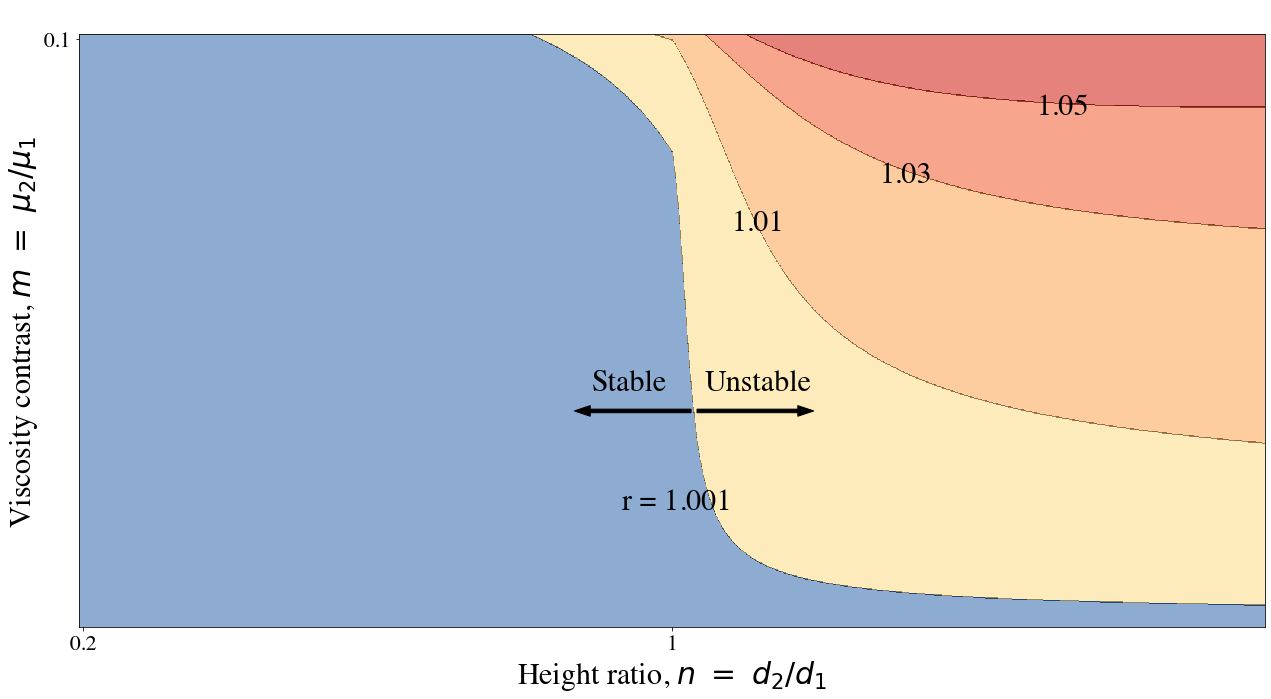

In [13]:
title = " "
lines = make_line_matrix(d_matrix)
fig, ax = plt.subplots(figsize=(20,10))

im = create_phase_diagram(params, ranges, ax, color=custom_map, title=title, matrix=d_matrix)
im = create_phase_diagram(params, ranges, ax, color="Greys", title=title, matrix=lines, opacity=.4)


# Non-log text positions/vals
# plt.text(900, 450, "$\u03C1_1 = 1$", rotation=360, fontsize=F_SIZE)
# plt.text(1200, 225, "$.99$", rotation=360, fontsize=F_SIZE)
# plt.text(1500, 180, "$.97$", rotation=360, fontsize=F_SIZE)
# plt.text(1700, 130, "$.95$", rotation=360, fontsize=F_SIZE)

plt.text(915, 800, "r = 1.001", fontsize=F_SIZE)
plt.text(865, 600, "Stable", fontsize=F_SIZE)
#plt.text(940, 635, "<------->", rotation=360, fontsize=F_SIZE)
plt.arrow(1032, 635, -170, 0, width=6, color="black")
plt.arrow(1042, 635, 170, 0, width=6, color="black")
plt.text(1055, 600, "Unstable", fontsize=F_SIZE)
plt.text(1100, 330, "1.01", fontsize=F_SIZE)
plt.text(1350, 250, "1.03", fontsize=F_SIZE)
plt.text(1615, 135, "1.05", fontsize=F_SIZE)

plt.tight_layout()

fig.savefig("phase_diagrams/final_diverging_color")

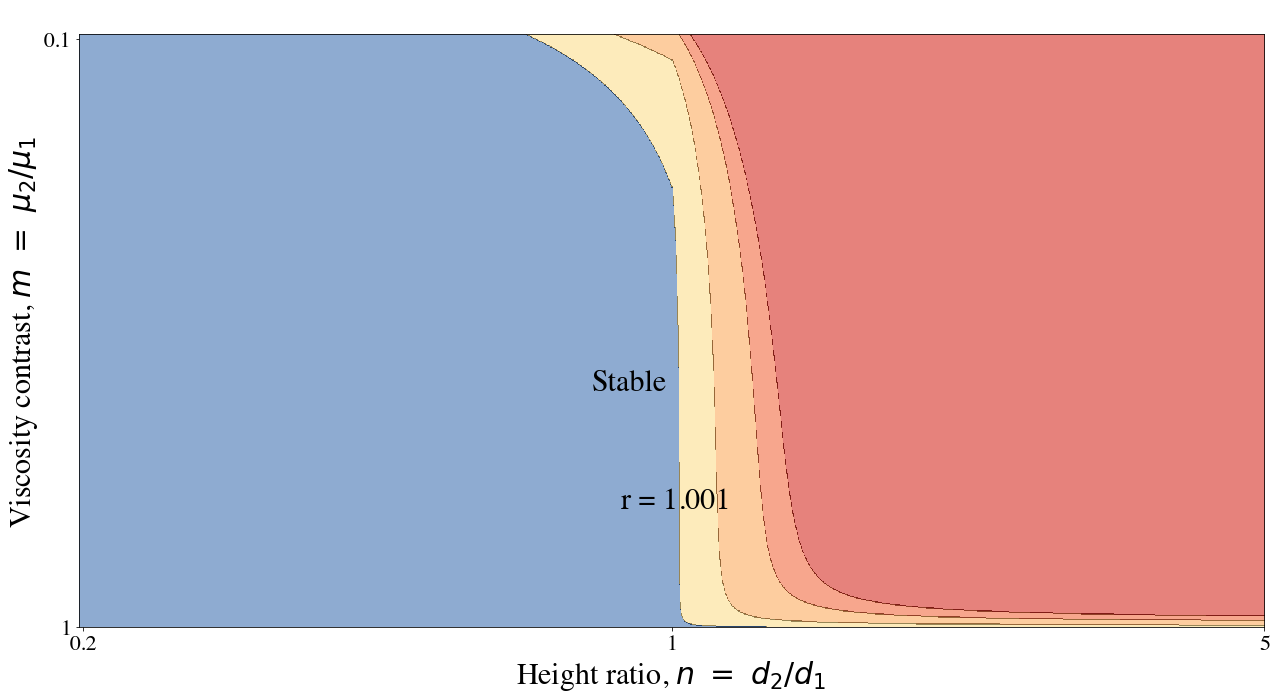

In [10]:
title = " "
lines = make_line_matrix(d_matrix)
fig, ax = plt.subplots(figsize=(20,10))

im = create_phase_diagram(params, ranges, ax, color=custom_map, title=title, matrix=d_matrix)
im = create_phase_diagram(params, ranges, ax, color="Greys", title=title, matrix=lines, opacity=.4)


# Non-log text positions/vals
# plt.text(900, 450, "$\u03C1_1 = 1$", rotation=360, fontsize=F_SIZE)
# plt.text(1200, 225, "$.99$", rotation=360, fontsize=F_SIZE)
# plt.text(1500, 180, "$.97$", rotation=360, fontsize=F_SIZE)
# plt.text(1700, 130, "$.95$", rotation=360, fontsize=F_SIZE)

plt.text(915, 800, "r = 1.001", fontsize=F_SIZE)
plt.text(865, 600, "Stable", fontsize=F_SIZE)
#plt.text(940, 635, "<------->", rotation=360, fontsize=F_SIZE)
# plt.arrow(1032, 635, -170, 0, width=6, color="black")
# plt.arrow(1042, 635, 170, 0, width=6, color="black")
# plt.text(1055, 600, "Unstable", fontsize=F_SIZE)
# plt.text(1100, 330, "1.01", fontsize=F_SIZE)
# plt.text(1350, 250, "1.03", fontsize=F_SIZE)
# plt.text(1615, 135, "1.05", fontsize=F_SIZE)

plt.tight_layout()

fig.savefig("phase_diagrams/faster_U0")

# Generate box plots using field data and model data

In [6]:
np.random.seed(1)

RHO1_MIN = .95
RHO1_MAX = 1

MU1_MIN = 1.0001
MU1_MAX = 10

GRANULARITY = 1000
N_SAMPLES = int(1e4)

params = {}
params["dP"] = 0 
params["g"] = 1
params["U0"] = 1
params["rho2"] = 1
params["d1"] = 1
params["mu2"] = 1
params["verbose"] = False

mu1_vals = np.linspace(MU1_MIN, MU1_MAX, GRANULARITY)
mu1s =  np.random.choice(mu1_vals, size=N_SAMPLES)

# These ranges should correspond with the ranges of the stacked phase diagram
small_d2s = np.random.choice(np.linspace(.2, 1, GRANULARITY), size=N_SAMPLES // 2)
large_d2s = np.random.choice(np.linspace(1, 5, GRANULARITY), size=N_SAMPLES // 2)

d2s = np.concatenate([small_d2s, large_d2s])
np.random.shuffle(d2s)

# rho1s = [.999, .99, .97, .95]
rho1s = [.95]
stable_d2s = []

for idx, rho1 in enumerate(rho1s):
    stable_d2s.append([])
    rho1s = np.random.choice(np.linspace(rho1, 1, GRANULARITY), size=N_SAMPLES)
    
    for mu1, d2, rho1 in zip(mu1s, d2s, rho1s):

        params["mu1"] = mu1
        params["d2"] = d2
        params["rho1"] = rho1

        if yihJ(**params) <= 0:
            stable_d2s[idx].append(d2)
            
stable_d2s.append(duraiswami_data)
stable_d2s.append(aubele_data)
# combined_papers = duraiswami_data + aubele_data
# stable_d2s.append(combined_papers)

In [7]:
#fig, ax = plt.subplots(figsize=(13,5))
fig, ax = plt.subplots(figsize=(8,5))

print("not dead 2")
# labels=["$r = 1.001$", "$r = 1.01$", "$r = 1.03$", "$r = 1.05$", "Duraiswami 2014", "Aubele 1988"]
labels=["r = 1.05", "Duraiswami 2014", "Aubele 1988"]
ax.boxplot(stable_d2s, labels=labels, showfliers=False, widths=.8)
print("not dead 3")
#ax.axvline(4.5, color='black', linestyle='--')
plt.text(400, 200, "N = 1000", fontsize=F_SIZE)
ax.axvline(1.5, color='black', linestyle='--')
ax.set_ylabel("n  =  $d_2 / d_1$")
# ax.set_ylim((0, 2))
# print("not dead 4")

# fig.savefig(f"box_plots/box_plot_single_r_{N_SAMPLES}_samples")
# print("not dead 4")

In [3]:
# New plan, we want to generate a grid of box plots based on different ranges of r to sample from
# instead of hard-setting the r value

print(len(duraiswami_data))
print(len(aubele_data))

7
29
